<a href="https://colab.research.google.com/github/sirdr/ACKTR.jl/blob/master/3_0_lkac_dynamics_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import os
import numpy as np
import math
import scipy.interpolate as interp
import scipy.optimize as opt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
import tensorflow as tf
from tensorflow import keras
import progressbar

In [2]:
# run for Colab (Drive)

from google.colab import drive

drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
files = ['Fisher-051220.csv', 'Fisher-051420.csv', 'Fisher-051820.csv', 'Fisher-052720.csv', 'Fisher-061220.csv']
data_dir = '/content/gdrive/My Drive/Melonfrost/Science/Project Maia/Experiments/Data/Dev/Wiki/'
dframe_dict = {}
for f in files:
    data_path = os.path.join(data_dir, f)
    dframe = pd.read_csv(data_path, index_col=0)
    exp = f.split('-')[-1].split('.')[0]
    exp_col = [exp for _ in range(len(dframe.index))]
    dframe["Experiment"] = exp_col
    dframe_dict[exp] = dframe

In [4]:
dframes_list = [frame for i, frame in dframe_dict.items()]

In [5]:
final_frame = pd.concat(dframes_list, ignore_index=True)

In [175]:
final_frame[(final_frame["Experiment"] == "052720") & (final_frame["Done"] == 1)]

,Posix,Optical Density High Power,Culture Temperature,Stirring Speed,LED Intensity,Done,Trajectory,Valve 1 Setting,Growth Rate,Params,Growth Fit,Experiment
20385,1.590595e+09,1.01548,26.840000,300.0,2000.00,1.0,0.0,1.0,0.000034,6 5 4 ...,0.998356,052720
21168,1.590620e+09,1.00101,27.468667,300.0,8770.48,1.0,1.0,1.0,0.000006,6 5 4 ...,0.989234,052720
22771,1.590669e+09,1.00008,27.742759,300.0,8369.99,1.0,2.0,1.0,0.000012,6 5 4 ...,0.993171,052720
23498,1.590693e+09,1.00288,26.840000,300.0,1969.46,1.0,3.0,1.0,0.000033,6 5 4 ...,0.994354,052720
24648,1.590728e+09,1.00114,27.793448,300.0,7856.74,1.0,4.0,1.0,0.000015,6 5 4 ...,0.996946,052720
25433,1.590753e+09,1.00074,27.307333,300.0,4720.80,1.0,5.0,1.0,0.000019,6 5 4 ...,0.996465,052720
26316,1.590781e+09,1.00035,27.139355,300.0,4151.16,1.0,6.0,1.0,0.000022,6 5 4 ...,0.989356,052720
27090,1.590805e+09,1.00710,27.136296,300.0,3651.75,1.0,7.0,1.0,0.000028,6 5 4 ...,0.998276,052720
27933,1.590832e+09,1.00081,27.457000,300.0,4929.00,1.0,8.0,1.0,0.000013,6 5 4 ...,0.992285,052720
29216,1.590871e+09,1.00744,27.927333,300.0,8836.82,1.0,9.0,1.0,0.000023,6 5 4 ...,0.991449,052720


In [140]:
final_frame

,Posix,Optical Density High Power,Culture Temperature,Stirring Speed,LED Intensity,Done,Trajectory,Valve 1 Setting,Growth Rate,Params,Growth Fit,Experiment
0,1.589335e+09,0.502737,27.650000,300.0,2000.00,0.0,0.0,1.0,0.000022,6 5 4 ...,0.498092,051220
1,1.589335e+09,0.500463,27.650000,300.0,2000.00,0.0,0.0,1.0,0.000022,6 5 4 ...,0.498760,051220
2,1.589335e+09,0.500379,27.650000,300.0,2000.00,0.0,0.0,1.0,0.000022,6 5 4 ...,0.499428,051220
3,1.589335e+09,0.502273,27.650000,300.0,2000.00,0.0,0.0,1.0,0.000022,6 5 4 ...,0.500096,051220
4,1.589335e+09,0.499268,27.359091,300.0,2000.00,0.0,0.0,1.0,0.000022,6 5 4 ...,0.500853,051220
...,...,...,...,...,...,...,...,...,...,...,...,...
47926,1.592237e+09,0.661632,27.177000,300.0,15.51,0.0,8.0,1.0,-0.000002,7 6 5 ...,0.664363,061220
47927,1.592237e+09,0.671108,27.160000,300.0,15.51,0.0,8.0,1.0,-0.000002,7 6 5 ...,0.664292,061220
47928,1.592237e+09,0.671450,27.160000,300.0,15.51,0.0,8.0,1.0,-0.000002,7 6 5 ...,0.664221,061220
47929,1.592238e+09,0.672416,27.313000,300.0,15.51,0.0,8.0,1.0,-0.000002,7 6 5 ...,0.664149,061220


In [141]:
columns_to_norm = ["Optical Density High Power", "Culture Temperature", "LED Intensity", "Growth Rate"]
data_to_norm = final_frame[columns_to_norm].values
data_to_norm.shape

(47931, 4)

In [142]:
min_max_scaler = MinMaxScaler()
data_normed = min_max_scaler.fit_transform(data_to_norm)

In [51]:
norm_params = min_max_scaler.get_params()

In [157]:
data_reg = min_max_scaler.inverse_transform(data_normed)


In [158]:
data_reg

array([[ 5.02737000e-01,  2.76500000e+01,  2.00000000e+03,
         2.22797472e-05],
       [ 5.00463000e-01,  2.76500000e+01,  2.00000000e+03,
         2.22720488e-05],
       [ 5.00379000e-01,  2.76500000e+01,  2.00000000e+03,
         2.22641379e-05],
       ...,
       [ 6.71450000e-01,  2.71600000e+01,  1.55100000e+01,
        -2.38710312e-06],
       [ 6.72416000e-01,  2.73130000e+01,  1.55100000e+01,
        -2.41077849e-06],
       [ 6.63859000e-01,  2.71770000e+01,  1.55100000e+01,
        -2.43450133e-06]])

In [63]:
final_frame[columns_to_norm] = data_normed

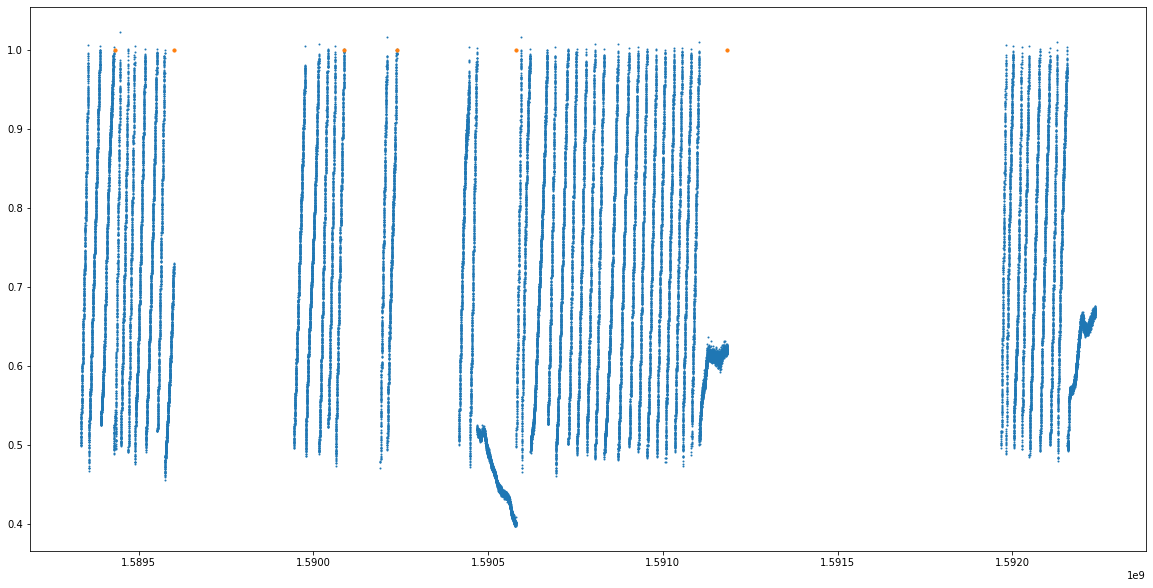

In [178]:
y = states[:, 0]
x = final_frame["Posix"]
fig, ax = plt.subplots(1, 1, figsize=(20, 10))
ax.scatter(x, y,s=1)
ax.scatter(frame_prev.loc[indices, "Posix"], np.ones(len(indices)), s=10)
#plt.xlim(1.5893*1e9,1.5895*1e9)

In [68]:
def create_training_tuples(frame):
    state_cols = ["Optical Density High Power", "Culture Temperature", "Growth Rate"]
    action_cols = ["LED Intensity"]
    states = []
    actions = []
    next_states = []
    frame_copy = frame.copy(deep=True)
    states = frame_copy[state_cols]
    actions = frame_copy[action_cols]
    states
    # for index, row in frame.iterrows():
    #     state = row.copy(deep=True)[state_cols]
    #     action = row.copy(deep=True)[action_cols]
    #     next_state = None
    #     next_row = frame.loc[index + 1]

    #     if index + 1 < len(frame.index):
    #         current_t = row["Trajectory"]
    #         next_t = next_row["Trajectory"]
    #         if (next_t == current_t and next_row["Experiment"] == row["Experiment"]) or (next_t == current_t + 1 and next_row["Experiment"] == row["Experiment"]):
    #             next_state = next_row.copy(deep=True)[state_cols]
    #     states.append(state)
    #     actions.append(actions)
    #     next_states.append(next_state)

    # new_df = pd.DataFrame([states, actions, next_states], columns=["state", "action", "next_state"])
    # return new_df

In [7]:
time_cols = ["Posix"]
state_cols = ["Optical Density High Power", "Culture Temperature", "Growth Rate"]
action_cols = ["LED Intensity"]
times = []
states = []
actions = []
next_states = []
frame_copy = final_frame.copy(deep=True)
# states = [list(v) for v in frame_copy[state_cols].values]
# actions = [list(v) for v in frame_copy[action_cols].values]
times = frame_copy[time_cols].values
states = frame_copy[state_cols].values
actions = frame_copy[action_cols].values
next_states = frame_copy[state_cols].values[1:]
ind_2_keep = np.arange(len(next_states))
frame_prev = frame_copy.drop(index = final_frame.index[-1])
frame_next = frame_copy.drop(index = final_frame.index[0]).reset_index(drop=True)
indices = frame_prev.index[((frame_prev["Trajectory"] != frame_next["Trajectory"]) | (frame_prev["Experiment"] != frame_next["Experiment"])) &  ((frame_prev["Trajectory"] + 1 != frame_next["Trajectory"]) | (frame_prev["Experiment"] != frame_next["Experiment"]))]
# for i in indices.to_list():
#     next_states[i] = None

In [433]:
states[1] - next_states[1]

array([8.4000000e-05, 0.0000000e+00, 7.9109396e-09])

In [8]:
ind_2_keep = np.array([i for i in ind_2_keep if i not in indices])

In [9]:
states = states[ind_2_keep]
actions = actions[ind_2_keep]
next_states = next_states[ind_2_keep]
times = times[ind_2_keep]

In [205]:
residual_states = next_states - states

In [206]:
residual_states

array([[-2.27400000e-03,  0.00000000e+00, -7.69844748e-09],
       [-8.40000000e-05,  0.00000000e+00, -7.91093960e-09],
       [ 1.89400000e-03,  0.00000000e+00, -8.11875921e-09],
       ...,
       [ 3.42000000e-04,  0.00000000e+00, -2.36275949e-08],
       [ 9.66000000e-04,  1.53000000e-01, -2.36753681e-08],
       [-8.55700000e-03, -1.36000000e-01, -2.37228392e-08]])

In [10]:
num_samples = states.shape[0]
train_percent = 0.9
num_samples_train = round(num_samples*train_percent)
num_samples_test = num_samples - num_samples_train

In [11]:
state_action_time_total = np.concatenate([states, actions, times], axis=1)

In [58]:
start_test = np.random.randint(low=0, high=num_samples-num_samples_test-1)
end_test = start_test + num_samples_test

In [59]:
indices = np.arange(num_samples)
test_indices = indices[start_test:end_test]
train_indices = np.concatenate([indices[:start_test],indices[end_test:]])

In [60]:
state_action_time_fit = state_action_time_total[train_indices]
next_states_train = next_states[train_indices]
state_action_time_test = state_action_time_total[test_indices]
next_states_test = next_states[test_indices]

In [61]:
experiment = {}
min_max_scaler_states = MinMaxScaler()
min_max_scaler_actions = MinMaxScaler()
state_action_time_fit[:, 0:-2] = min_max_scaler_states.fit_transform(state_action_time_fit[:, 0:-2])
state_action_time_fit[:,-2] = min_max_scaler_actions.fit_transform(state_action_time_fit[:,-2].reshape(-1, 1))[:, 0]

In [62]:
next_states_train = min_max_scaler_states.transform(next_states_train)
next_states_test = min_max_scaler_states.transform(next_states_test)

In [63]:
state_action_time_test[:, 0:-2] = min_max_scaler_states.transform(state_action_time_test[:, 0:-2])
state_action_time_test[:, -2] = min_max_scaler_actions.transform(state_action_time_test[:,-2].reshape(-1, 1))[:, 0]

In [64]:
#seed = 7
#state_action_time_train, state_action_time_valid, next_states_train, next_states_valid = train_test_split(state_action_time_fit, next_states_fit, test_size = 0.1, random_state = seed)
state_action_train = state_action_time_fit[:, 0:-1]
#state_action_valid = state_action_time_valid[:, 0:-1]
time_train = state_action_time_fit[:, -1]
#time_valid = state_action_time_valid[:, -1]

In [17]:
experiment["action_fit"] = min_max_scaler_actions
experiment["states_fit"] = min_max_scaler_states
experiment["seed"] = seed
experiment["train"] = (time_train, state_action_train, next_states_train)
experiment["test"] = (time_test, state_action_test, next_states_test)

NameError: ignored

In [65]:
res_states_train = next_states_train - state_action_train[:, 0:-1]

In [66]:
state_action_test = state_action_time_test[:, 0:-1]
time_test = state_action_time_test[:, -1]

In [67]:
initializer = tf.keras.initializers.GlorotUniform(seed=7)
model = tf.keras.Sequential()
model.add(tf.keras.Input(shape=(state_action_train.shape[-1],)))
model.add(tf.keras.layers.Dense(10000, activation='relu', kernel_initializer=initializer))
#model.add(tf.keras.layers.Dense(5, activation='relu', kernel_initializer=initializer))
model.add(tf.keras.layers.Dense(3, kernel_initializer=initializer))
model.compile(optimizer='adam', loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()])
model.fit(state_action_train, res_states_train, validation_split=0.1, batch_size=100, epochs=10)
res_states_test = next_states_test - state_action_test[:, 0:-1]
preds = model.predict(state_action_test)
m = keras.metrics.MeanSquaredError()
r = keras.metrics.RootMeanSquaredError() 
# m.update_state(preds, next_states_test)
# r.update_state(preds, next_states_test)
m.update_state(preds, res_states_test)
r.update_state(preds, res_states_test)
print("MSE {} | RMSE {}".format(m.result().numpy(), r.result().numpy()))

Epoch 1/10
389/389 [==============================] - 5s 14ms/step - loss: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0013 - val_root_mean_squared_error: 0.0355
Epoch 2/10
389/389 [==============================] - 5s 13ms/step - loss: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0370
Epoch 3/10
389/389 [==============================] - 5s 12ms/step - loss: 0.0014 - root_mean_squared_error: 0.0379 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0393
Epoch 4/10
389/389 [==============================] - 5s 12ms/step - loss: 0.0014 - root_mean_squared_error: 0.0377 - val_loss: 0.0014 - val_root_mean_squared_error: 0.0373
Epoch 5/10
389/389 [==============================] - 5s 12ms/step - loss: 0.0014 - root_mean_squared_error: 0.0376 - val_loss: 0.0015 - val_root_mean_squared_error: 0.0386
Epoch 6/10
389/389 [==============================] - 5s 12ms/step - loss: 0.0014 - root_mean_squared_error: 0.0374 - val_loss: 0.0013 

In [68]:
autoreg_limit = 500
autoreg_preds = []
sa = state_action_test[0][np.newaxis, :]
#sa.shape
for sa_ in progressbar.progressbar(state_action_test[1:autoreg_limit]):
    p = model.predict(sa)
    s_p = p+sa[:, :-1]
    autoreg_preds.append(s_p)
    sa_ = sa_[np.newaxis, :]
    sa = np.concatenate([s_p, np.array(sa_[:,-1][None, :])], axis=1)

100% (499 of 499) |######################| Elapsed Time: 0:00:18 Time:  0:00:18


In [69]:
autoreg_preds_ = np.array(autoreg_preds)[:, 0, :]

In [558]:
np.array(autoreg_preds).shape

(4791, 1, 3)

In [487]:
sa = state_action_test[0][np.newaxis, :]
sa[0][-1]

0.5272855030935737

In [355]:


#regr.score(state_action_test, res_states_test)

MSE 0.0013193772174417973 | RMSE 0.03632323071360588


In [332]:
#regr = MLPRegressor(random_state=7, max_iter=500).fit(state_action_train, res_states_train)
scorer = make_scorer(mean_squared_error, greater_is_better=False)
regr = MLPRegressor(random_state=7, max_iter=500)
scores = cross_val_score(regr, state_action_train, res_states_train, cv=5, scoring=scorer)
scores

array([-0.00147609, -0.0011699 , -0.00134192, -0.00144853, -0.00134607])

In [326]:
res_states_test = next_states_test - state_action_test[:, 0:-1]
preds = regr.predict(state_action_test)
regr.score(state_action_test, res_states_test)

NotFittedError: ignored

In [338]:
preds

array([[ 0.0070626 ],
       [-0.02697434],
       [ 0.00282706],
       ...,
       [ 0.0081666 ],
       [ 0.02121495],
       [ 0.0143771 ]], dtype=float32)

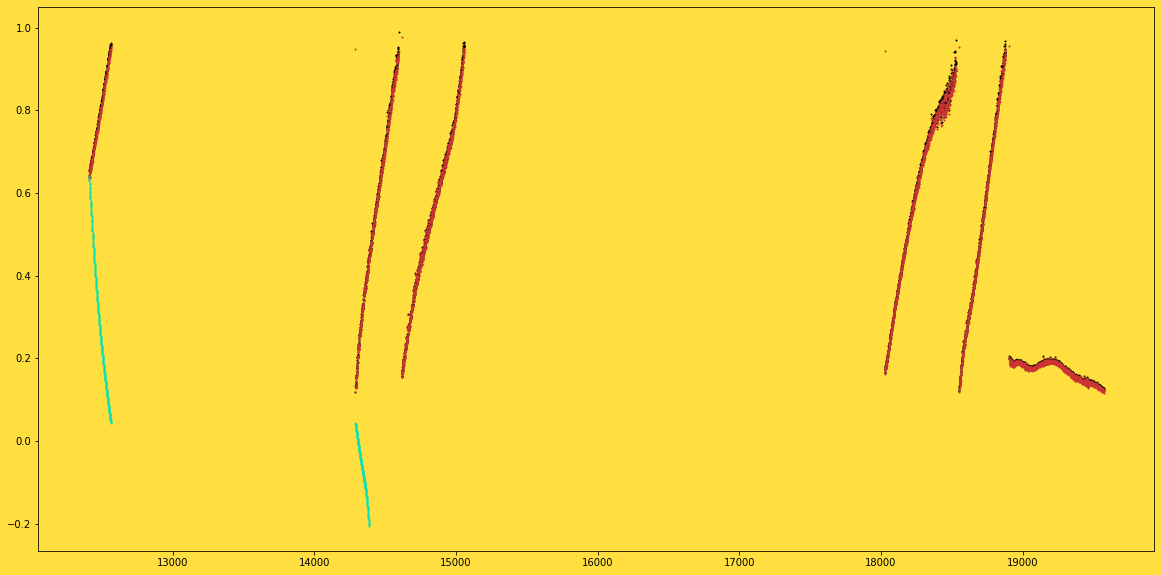

In [76]:
index = 0
autoreg_pred = autoreg_preds_[:, index]
opt_pred = preds[:, index] + state_action_test[:, index]
opt_true = next_states_test[:, index] #+ state_action_test[:, index]

good = np.divide(state_action_test[:, 2],state_action_test[:, 0])

pred = preds[:, index]

min_time = min(min(time_test), min(time_train))
x = (time_test - min_time)/60.

x_train = (time_train - min_time)/60.
opt_train = state_action_train[:, index]

fig, ax = plt.subplots(1, 1 , figsize=(20, 10))
fig.patch.set_facecolor('#ffdf40')
ax.set_facecolor("#ffdf40")
# ax.scatter(x[:-1][0:3], state_action_test[:-1, index][0:3], s=1, c='#00e3b6')
# #ax.scatter(x[1:][0:3], next_states_test[:-1, index][0:3], s=1, c='k')
# ax.scatter(x[1:][0:3], opt_true[:-1][0:3], s=1, c='k')
# ax.scatter(x[1:][0:3], opt_pred[:-1][0:3], s=1, c='#cc3333')

#ax.scatter(state_action_test[:, 0], state_action_test[:, 2], s=1, c='k')
#ax.scatter(x, good, s=1, c='k')
ax.scatter(x[:-1], state_action_test[:-1, index], s=1, c='k')
# ax.scatter(x[1:][0:3], next_states_test[:-1, index][0:3], s=1, c='k')
# ax.scatter(x[1:], opt_true[:-1], s=1, c='k')
ax.scatter(x[1:], opt_pred[:-1], s=1, c='#cc3333')
# ax.scatter(x[1:autoreg_limit], autoreg_pred, s=1, c='#00e3b6')



#ax.plot(x_g, y_g, c='g')
#plt.ylim(0.0, 1.0)
#plt.xlim(45800, 48000)
#plt.xlim(1500, 1595)
#plt.xlim(910, 925)
#plt.xlim(350, 375)
plt.show()